In [1]:
#improt basic packages
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
import pandas as pd
import numpy as np
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from IPython.core.interactiveshell import InteractiveShell
from lightgbm import LGBMRegressor
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import optuna.integration.lightgbm as oplgb

InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('/home/wzabsd/Desktop/NAIST-PBL1/datasets/CPE.csv')
df
smiles_l=df['mol'].tolist()
mols_l=[Chem.MolFromSmiles(smile) for smile in smiles_l]

,SAMPLE_ID,mol,Class,Class_index
0,NCGC00093656-03,Br/C=C/C=1C(=O)NC(=O)N([C@@H]2O[C@H](CO)[C@@H]...,Inactive,0
1,NCGC00262958-01,Br/C=C\C=1C(=O)NC(=O)N([C@@H]2[C@@H](O)[C@H](O...,Inactive,0
2,NCGC00160445-02,BrC(C(=O)NC(=O)N)C(C)C,Inactive,0
3,NCGC00090868-06,BrC(Cl)C(F)(F)F,Inactive,0
4,NCGC00166217-02,BrC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,Inactive,0
...,...,...,...,...
8449,NCGC00013822-04,c1(c(c(-c2ccncc2)sc1-c1ccncc1)-c1ccncc1)-c1ccncc1,Active,1
8450,NCGC00090793-05,c12c(cccc1)cccc2,Inactive,0
8451,NCGC00247735-02&NCGC00247735-03,n1c2c(ncc1)cc1c(c2)C2CNCC1C2,Inactive,0
8452,NCGC00094646-04,s1c2c(c3c1cccc3)cccc2,Inactive,0


In [3]:
des_l=[des_name[0] for des_name in Descriptors._descList]
desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(des_l)
descriptors = pd.DataFrame([desc_calc.CalcDescriptors(mol) for mol in mols_l])
descriptors.columns = des_l
descriptors.index = smiles_l

In [4]:
descriptors["SMILES"]=smiles_l
descriptors=descriptors.dropna(axis=1, how='any')
descriptors["SAMPLE_ID"]=df["SAMPLE_ID"].tolist()
descriptors["Class"]=df["Class"].tolist()
descriptors["Class_index"]=df["Class_index"].tolist()
descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SMILES,SAMPLE_ID,Class,Class_index
Br/C=C/C=1C(=O)NC(=O)N([C@@H]2O[C@H](CO)[C@@H](O)C2)C=1,11.732651,-0.843523,11.732651,0.175242,0.694561,333.138,320.034,332.000784,104,0,...,0,0,0,0,0,0,Br/C=C/C=1C(=O)NC(=O)N([C@@H]2O[C@H](CO)[C@@H]...,NCGC00093656-03,Inactive,0
Br/C=C\C=1C(=O)NC(=O)N([C@@H]2[C@@H](O)[C@H](O)[C@@H](CO)O2)C=1,11.767095,-1.392082,11.767095,0.165938,0.527270,349.137,336.033,347.995698,110,0,...,0,0,0,0,0,0,Br/C=C\C=1C(=O)NC(=O)N([C@@H]2[C@@H](O)[C@H](O...,NCGC00262958-01,Inactive,0
BrC(C(=O)NC(=O)N)C(C)C,10.936088,-0.819352,10.936088,0.133657,0.672535,223.070,211.982,222.000390,64,0,...,0,0,0,0,0,1,BrC(C(=O)NC(=O)N)C(C)C,NCGC00160445-02,Inactive,0
BrC(Cl)C(F)(F)F,10.999421,-4.317901,10.999421,1.916667,0.523506,197.381,196.373,195.890224,44,0,...,0,0,0,0,0,0,BrC(Cl)C(F)(F)F,NCGC00090868-06,Inactive,0
BrC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,12.904583,-8.579167,12.904583,0.359590,0.295628,498.958,498.958,497.891192,158,0,...,0,0,0,0,0,0,BrC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,NCGC00166217-02,Inactive,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1(c(c(-c2ccncc2)sc1-c1ccncc1)-c1ccncc1)-c1ccncc1,4.215813,1.134426,4.215813,1.134426,0.376535,392.487,376.359,392.109568,138,0,...,0,0,0,1,0,0,c1(c(c(-c2ccncc2)sc1-c1ccncc1)-c1ccncc1)-c1ccncc1,NCGC00013822-04,Active,1
c12c(cccc1)cccc2,2.120370,1.310185,2.120370,1.310185,0.511431,128.174,120.110,128.062600,48,0,...,0,0,0,0,0,0,c12c(cccc1)cccc2,NCGC00090793-05,Inactive,0
n1c2c(ncc1)cc1c(c2)C2CNCC1C2,4.389983,0.694589,4.389983,0.694589,0.721763,211.268,198.164,211.110947,80,0,...,0,0,0,0,0,0,n1c2c(ncc1)cc1c(c2)C2CNCC1C2,NCGC00247735-02&NCGC00247735-03,Inactive,0
s1c2c(c3c1cccc3)cccc2,2.188657,1.377870,2.188657,1.377870,0.494058,184.263,176.199,184.034671,62,0,...,0,0,0,1,0,0,s1c2c(c3c1cccc3)cccc2,NCGC00094646-04,Inactive,0


In [5]:
from sklearn.feature_selection import VarianceThreshold
sel_model = VarianceThreshold(threshold = 0.01)
descriptors_selected=sel_model.fit_transform(descriptors.loc[:,"MaxEStateIndex":"fr_urea"])
l=sel_model.get_support().tolist()
selected_feature_Variance=descriptors.loc[:,"MaxEStateIndex":"fr_urea"].columns[l].tolist()
descriptors_selected_Variance=descriptors[selected_feature_Variance]
descriptors_selected_Variance["Class_index"]=df["Class_index"].tolist()
descriptors_selected_Variance

/tmp/ipykernel_15671/4208537544.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptors_selected_Variance["Class_index"]=df["Class_index"].tolist()


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan1,...,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,Class_index
Br/C=C/C=1C(=O)NC(=O)N([C@@H]2O[C@H](CO)[C@@H](O)C2)C=1,11.732651,-0.843523,11.732651,0.175242,0.694561,333.138,320.034,332.000784,104,1.578947,...,0,0,0,0,0,0,0,0,0,0
Br/C=C\C=1C(=O)NC(=O)N([C@@H]2[C@@H](O)[C@H](O)[C@@H](CO)O2)C=1,11.767095,-1.392082,11.767095,0.165938,0.527270,349.137,336.033,347.995698,110,1.400000,...,0,0,0,0,0,0,0,0,0,0
BrC(C(=O)NC(=O)N)C(C)C,10.936088,-0.819352,10.936088,0.133657,0.672535,223.070,211.982,222.000390,64,1.454545,...,0,0,0,0,0,0,0,0,1,0
BrC(Cl)C(F)(F)F,10.999421,-4.317901,10.999421,1.916667,0.523506,197.381,196.373,195.890224,44,1.428571,...,0,0,0,0,0,0,0,0,0,0
BrC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,12.904583,-8.579167,12.904583,0.359590,0.295628,498.958,498.958,497.891192,158,0.307692,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1(c(c(-c2ccncc2)sc1-c1ccncc1)-c1ccncc1)-c1ccncc1,4.215813,1.134426,4.215813,1.134426,0.376535,392.487,376.359,392.109568,138,0.379310,...,4,0,0,0,0,0,1,0,0,1
c12c(cccc1)cccc2,2.120370,1.310185,2.120370,1.310185,0.511431,128.174,120.110,128.062600,48,0.500000,...,0,0,0,0,0,0,0,0,0,0
n1c2c(ncc1)cc1c(c2)C2CNCC1C2,4.389983,0.694589,4.389983,0.694589,0.721763,211.268,198.164,211.110947,80,0.937500,...,0,0,0,0,0,0,0,0,0,0
s1c2c(c3c1cccc3)cccc2,2.188657,1.377870,2.188657,1.377870,0.494058,184.263,176.199,184.034671,62,0.615385,...,0,0,0,0,0,0,1,0,0,0


In [6]:
from feature_selector import FeatureSelector 
fs = FeatureSelector(data = descriptors_selected_Variance, labels = descriptors_selected_Variance["Class_index"])
fs.identify_collinear(correlation_threshold=0.9)
descriptors_selected_finall=fs.remove(methods = ['collinear'])
descriptors_selected_finall

48 features with a correlation magnitude greater than 0.90.

Removed 48 features.


,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,FpDensityMorgan1,BalabanJ,BertzCT,HallKierAlpha,Ipc,...,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,Class_index
Br/C=C/C=1C(=O)NC(=O)N([C@@H]2O[C@H](CO)[C@@H](O)C2)C=1,11.732651,-0.843523,0.175242,0.694561,333.138,1.578947,2.381025,593.483721,-1.22,2.205699e+04,...,0,0,0,0,0,0,0,0,0,0
Br/C=C\C=1C(=O)NC(=O)N([C@@H]2[C@@H](O)[C@H](O)[C@@H](CO)O2)C=1,11.767095,-1.392082,0.165938,0.527270,349.137,1.400000,2.455258,624.074744,-1.26,3.244155e+04,...,0,0,0,0,0,0,0,0,0,0
BrC(C(=O)NC(=O)N)C(C)C,10.936088,-0.819352,0.133657,0.672535,223.070,1.454545,3.931557,169.965218,-0.58,1.637844e+02,...,0,0,0,0,0,0,0,0,1,0
BrC(Cl)C(F)(F)F,10.999421,-4.317901,1.916667,0.523506,197.381,1.428571,3.541197,58.445472,0.56,1.708617e+01,...,0,0,0,0,0,0,0,0,0,0
BrC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,12.904583,-8.579167,0.359590,0.295628,498.958,0.307692,6.612914,473.861414,-0.71,5.152896e+04,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1(c(c(-c2ccncc2)sc1-c1ccncc1)-c1ccncc1)-c1ccncc1,4.215813,1.134426,1.134426,0.376535,392.487,0.379310,1.888348,1124.147276,-3.70,1.226845e+07,...,4,0,0,0,0,0,1,0,0,1
c12c(cccc1)cccc2,2.120370,1.310185,1.310185,0.511431,128.174,0.500000,2.888052,271.015182,-1.30,3.485705e+02,...,0,0,0,0,0,0,0,0,0,0
n1c2c(ncc1)cc1c(c2)C2CNCC1C2,4.389983,0.694589,0.694589,0.721763,211.268,0.937500,2.013737,515.606304,-1.48,1.247319e+04,...,0,0,0,0,0,0,0,0,0,0
s1c2c(c3c1cccc3)cccc2,2.188657,1.377870,1.377870,0.494058,184.263,0.615385,2.642438,512.884136,-1.34,2.395238e+03,...,0,0,0,0,0,0,1,0,0,0


In [7]:
from sklearn import preprocessing
descriptors_selected_finall.loc[:,"MaxEStateIndex":"fr_urea"] = preprocessing.scale(descriptors_selected_finall.loc[:,"MaxEStateIndex":"fr_urea"])
descriptors_selected_finall

/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,FpDensityMorgan1,BalabanJ,BertzCT,HallKierAlpha,Ipc,...,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,Class_index
Br/C=C/C=1C(=O)NC(=O)N([C@@H]2O[C@H](CO)[C@@H](O)C2)C=1,-0.034752,0.277986,0.053937,0.855522,-0.451088,2.030761,0.828063,-0.676420,0.907108,-0.012204,...,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923,0
Br/C=C\C=1C(=O)NC(=O)N([C@@H]2[C@@H](O)[C@H](O)[C@@H](CO)O2)C=1,-0.020451,-0.118351,0.015996,0.117203,-0.371464,1.286579,0.956353,-0.615659,0.875887,-0.012204,...,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923,0
BrC(C(=O)NC(=O)N)C(C)C,-0.365463,0.295450,-0.115647,0.758314,-0.998870,1.513415,3.507712,-1.517621,1.406648,-0.012204,...,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,4.954722,0
BrC(Cl)C(F)(F)F,-0.339168,-2.232273,7.155552,0.100593,-1.126718,1.405398,2.833087,-1.739124,2.296454,-0.012204,...,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923,0
BrC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,0.451802,-5.311064,0.805719,-0.905123,0.374159,-3.255963,8.141670,-0.914016,1.305179,-0.012204,...,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1(c(c(-c2ccncc2)sc1-c1ccncc1)-c1ccncc1)-c1ccncc1,-3.155533,1.707067,3.965538,-0.548050,-0.155722,-2.958128,-0.023390,0.377595,-1.028609,-0.012204,...,8.744398,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,5.393905,-0.182975,-0.182923,1
c12c(cccc1)cccc2,-4.025502,1.834054,4.682291,0.047300,-1.471144,-2.456220,1.704312,-1.316913,0.844666,-0.012204,...,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923,0
n1c2c(ncc1)cc1c(c2)C2CNCC1C2,-3.083223,1.389282,2.171860,0.975574,-1.057605,-0.636804,0.193309,-0.831102,0.704170,-0.012204,...,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923,0
s1c2c(c3c1cccc3)cccc2,-3.997152,1.882957,4.958314,-0.029374,-1.192003,-1.976374,1.279840,-0.836508,0.813445,-0.012204,...,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,5.393905,-0.182975,-0.182923,0


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

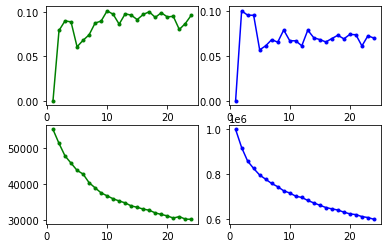

In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
Scores_active = []  # 存放轮廓系数,根据轮廓系数的计算公式，只有一个类簇时，轮廓系数为0
Scores_inactive = []   # 存放AH系数,根据轮廓系数的计算公式，只有一个类簇时，系数为0
sse_list_active = [] 
sse_list_inactive = []

df_active=descriptors_selected_finall[descriptors_selected_finall["Class_index"] == 1].loc[:,"MaxEStateIndex":"fr_urea"].values
df_inactive=descriptors_selected_finall[descriptors_selected_finall["Class_index"] == 0].loc[:,"MaxEStateIndex":"fr_urea"].values
for k in range(1,25):
    estimator_active = KMeans(n_clusters=k).fit(df_active)
    estimator_inactive = KMeans(n_clusters=k).fit(df_inactive)
    if k==1:
        Scores_active.append(0)
        Scores_inactive.append(0)
    else:
        Scores_active.append(metrics.silhouette_score(df_active, estimator_active.labels_, metric='euclidean'))
        Scores_inactive.append(metrics.silhouette_score(df_inactive, estimator_inactive.labels_, metric='euclidean'))
    sse_list_active.append(estimator_active.inertia_)
    sse_list_inactive.append(estimator_inactive.inertia_)
i = range(1, 25)
# plt.xlabel('k_number')
# plt.ylabel('silhouette_score')
plt.subplot(221)
plt.plot(i,Scores_active,'g.-')
plt.subplot(222)
plt.plot(i,Scores_inactive,'b.-')
plt.subplot(223)
plt.plot(i,sse_list_active,'g.-')
plt.subplot(224)
plt.plot(i,sse_list_inactive,'b.-')
plt.show()

#num_inactive=3
#num_active=3

In [ ]:
from sklearn.model_selection import StratifiedKFold
from flaml import AutoML
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay


automl = AutoML()
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'log_loss', 
    "estimator_list": ['lgbm'],  # list of ML learners
    "task": 'classification',  # task type    
    "log_file_name": '/home/wzabsd/Desktop/NAIST-PBL1/flaml_log/experiment_log',  # flaml log file
    "seed": 2021,    # random seed
    "eval_method":"cv",
    "n_splits":3,
    "split_type":"stratified",
    "verbose":0
}
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
descriptors_selected_finall["SMILES"]=smiles_l
descriptors_selected_finall.index=range(0,descriptors_selected_finall.shape[0],1)
X=descriptors_selected_finall.loc[:,"MaxEStateIndex":"fr_urea"]
y=descriptors_selected_finall.loc[:,"Class_index"]

best_config=[]
best_loss=[]
feature_name_list=[]
feature_importances_list=[]
auc_score=[]
index=1
# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y): 
    X_train, X_test = X.loc[train_index], X.loc[test_index] 
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    automl.fit(X_train=X_train, y_train=y_train, **settings)
    with open('/home/wzabsd/Desktop/NAIST-PBL1/flaml_model/automl{0}.pkl'.format(index), 'wb') as f:
        pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
        
    best_config.append(automl.best_config)
    best_loss.append(1-automl.best_loss)
    feature_name_list.append(automl.model.estimator.feature_name_)
    feature_importances_list.append(automl.model.estimator.feature_importances_)
    
    y_proba=automl.predict_proba(X_test)
    y_pred=[i[1] for i in y_proba]
    
    fpr, tpr, threshold = roc_curve(y_test,y_pred,pos_label=1)
    auc_score.append(roc_auc_score(y_test,y_pred))
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    prec, recall, threshold = precision_recall_curve(y_test, y_pred,
                                         pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    #f1_score=f1_score(y_test,y_pred,pos_label=1)
    
    index+=1
    

In [155]:
f1_score=(2*prec*recall)/(recall+prec)
f1_score.max()
prec

0.9805825242718447

array([0.78030303, 0.77862595, 0.78461538, 0.79069767, 0.796875  ,
       0.80314961, 0.80952381, 0.816     , 0.82258065, 0.82926829,
       0.83606557, 0.84297521, 0.85      , 0.85714286, 0.86440678,
       0.87179487, 0.87931034, 0.88695652, 0.89473684, 0.90265487,
       0.91071429, 0.91891892, 0.92727273, 0.9266055 , 0.93518519,
       0.94392523, 0.95283019, 0.96190476, 0.97115385, 0.98058252,
       0.98039216, 0.99009901, 0.99      , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [152]:
prec=[1,2,3]
recall=[2,3,4]
f1_score=(2*prec*recall)/(recall+prec)
f1_score.max()

TypeError: can't multiply sequence by non-int of type 'list'

In [150]:
auc_score

[]

In [ ]:
plt.barh(feature_name_list[0],feature_importances_list[0])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from flaml import AutoML
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay


automl = AutoML()
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'roc_auc', 
    "estimator_list": ['lgbm'],  # list of ML learners
    "task": 'classification',  # task type    
    "log_file_name": '/home/wzabsd/Desktop/NAIST-PBL1/flaml_log/experiment_log',  # flaml log file
    "seed": 2021,    # random seed
    "early_stop":True,
}

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
descriptors_selected_finall["SMILES"]=smiles_l
descriptors_selected_finall.index=range(0,descriptors_selected_finall.shape[0],1)

# negative_size=descriptors_selected_finall[descriptors_selected_finall["Class_index"]==0].shape[0]
# positive_size=descriptors_selected_finall[descriptors_selected_finall["Class_index"]==1].shape[0]
# weight=[(negative_size+positive_size)/(negative_size),(positive_size+negative_size)/(positive_size)]

X=descriptors_selected_finall.loc[:,"MaxEStateIndex":"fr_urea"]
y=descriptors_selected_finall.loc[:,"Class_index"]

best_config=[]
best_loss=[]
feature_name_list=[]
feature_importances_list=[]
auc_score=[]
index=1
# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y): 
    X_train, X_test = X.loc[train_index], X.loc[test_index] 
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    automl.fit(X_train=X_train, y_train=y_train, **settings)
    
    with open('/home/wzabsd/Desktop/NAIST-PBL1/flaml_model/automl{0}_noinner.pkl'.format(index), 'wb') as f:
        pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
    
    best_config.append(automl.best_config)
    best_loss.append(1-automl.best_loss)
    feature_name_list.append(automl.model.estimator.feature_name_)
    feature_importances_list.append(automl.model.estimator.feature_importances_)
    
    y_proba=automl.predict_proba(X_test)
    y_pred=[i[1] for i in y_proba]
    
    fpr, tpr, threshold = roc_curve(y_test,y_pred,pos_label=1)
    auc_score.append(roc_auc_score(y_test,y_pred))
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=True).plot()
    prec, recall, threshold = precision_recall_curve(y_test, y_pred,
                                         pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    #f1_score=f1_score(y_test,y_pred,pos_label=1)
    
    index+=1

In [ ]:
from sklearn.tree import ExtraTreeClassifier
from imbalanced_ensemble.ensemble import SelfPacedEnsembleClassifier
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
descriptors_selected_finall["SMILES"]=smiles_l
descriptors_selected_finall.index=range(0,descriptors_selected_finall.shape[0],1)
X=descriptors_selected_finall.loc[:,"MaxEStateIndex":"fr_urea"]
y=descriptors_selected_finall.loc[:,"Class_index"]

best_config=[]
best_loss=[]
feature_name_list=[]
feature_importances_list=[]
auc_score=[]
index=1

# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y): 
    X_train, X_test = X.loc[train_index], X.loc[test_index] 
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf = SelfPacedEnsembleClassifier(
        base_estimator=ExtraTreeClassifier(),
        n_estimators=100,
    ).fit(X_train, y_train)

    # Predict with an SPE classifier
    y_proba=clf.predict_proba(X_test)
    y_pred=[i[1] for i in y_proba]
    
    fpr, tpr, threshold = roc_curve(y_test,y_pred,pos_label=1)
    auc_score.append(roc_auc_score(y_test,y_pred))
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    prec, recall, threshold = precision_recall_curve(y_test, y_pred,
                                         pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    index+=1





In [140]:
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.ensemble import GradientBoostingClassifier


descriptors_selected_finall["SMILES"]=smiles_l
descriptors_selected_finall.index=smiles_l
iht = InstanceHardnessThreshold(random_state=2021,estimator=GradientBoostingClassifier(),n_jobs=-1)
X=descriptors_selected_finall.loc[:,"MaxEStateIndex":"fr_urea"]
y=descriptors_selected_finall.loc[:,"Class_index"]
X_resampled, y_resampled = iht.fit_resample(X, y)

In [144]:
X_resampled
y_resampled 

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,FpDensityMorgan1,BalabanJ,BertzCT,HallKierAlpha,Ipc,...,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-3.424443,1.631886,3.541192,0.948419,-0.898847,0.582805,1.552399,-1.296736,1.593976,-0.012204,...,-0.15916,-0.367258,7.050764,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
1,-2.589540,1.622286,3.487007,-0.059703,-1.040525,-0.376887,-0.174410,-1.397875,1.656418,-0.012204,...,-0.15916,-0.367258,7.050764,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
2,-0.988596,-0.042455,4.273227,0.142689,-1.467322,2.395556,2.342947,-1.734907,1.898383,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
3,0.190813,-0.022778,-0.196779,0.757633,-0.278514,1.182612,-0.323862,-0.386410,0.274878,-0.012204,...,-0.15916,-0.367258,-0.098949,3.821123,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
4,0.686916,-0.078195,-0.593085,-0.799506,0.730077,-1.033519,0.165088,0.219060,-0.396379,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,0.422527,0.176676,-0.561697,-0.480184,0.237915,0.723936,-0.840883,1.034864,-0.248078,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
1026,0.865784,-2.230956,-0.268673,-1.486035,0.889885,0.712287,-0.637906,1.048297,-0.927140,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
1027,0.781126,0.010535,-0.193159,-1.718982,1.359557,-0.543234,-1.042773,1.581417,-1.426680,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,2.712429,-0.182923
1028,0.080699,0.195385,2.048293,1.080334,-0.185090,0.102959,-0.426933,-0.219739,0.844666,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923


0       0
1       0
2       0
3       0
4       0
       ..
1025    1
1026    1
1027    1
1028    1
1029    1
Name: Class_index, Length: 1030, dtype: int64

[flaml.automl: 09-15 00:34:56] {1541} WARNING - Time taken to find the best model is 87% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.automl: 09-15 00:35:24] {1935} WARNING - All estimator hyperparameters local search has converged at least once, and the total search time exceeds 10 times the time taken to find the best model.
[flaml.automl: 09-15 00:35:24] {1943} WARNING - Stopping search as early_stop is set to True.
[flaml.automl: 09-15 00:36:24] {1541} WARNING - Time taken to find the best model is 90% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


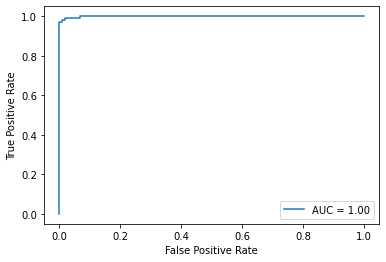

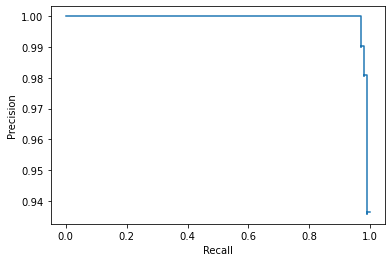

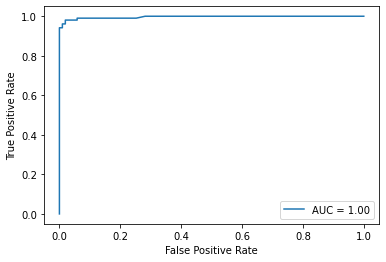

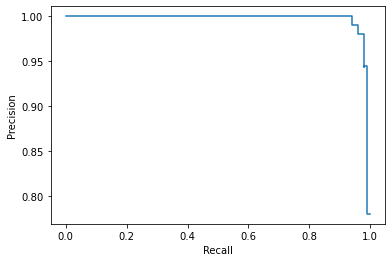

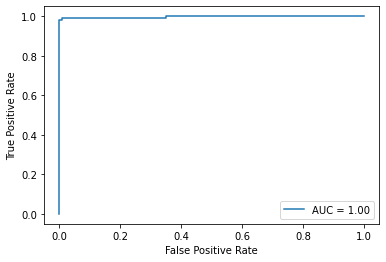

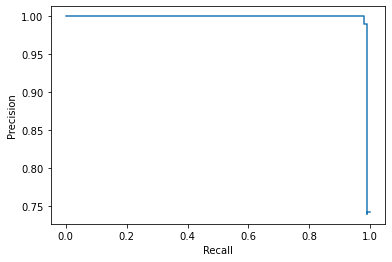

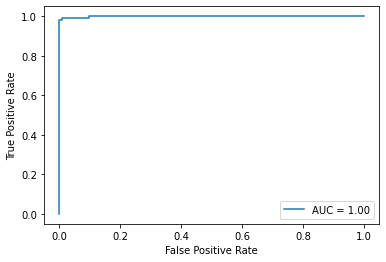

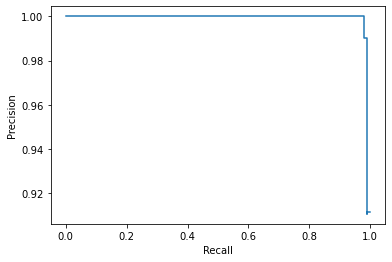

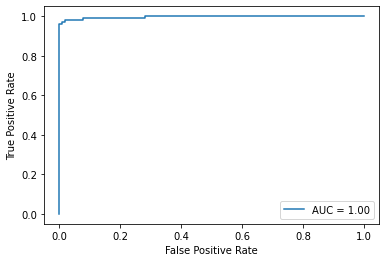

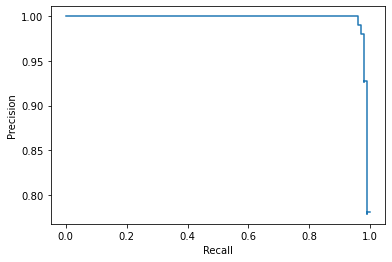

In [154]:
automl = AutoML()
settings = {
    "time_budget": 24,  # total running time in seconds
    "metric": 'log_loss', 
    "estimator_list": ['lgbm'],  # list of ML learners
    "task": 'classification',  # task type    
    "log_file_name": '/home/wzabsd/Desktop/NAIST-PBL1/flaml_log/experiment_log',  # flaml log file
    "seed": 2021,    # random seed
    "early_stop":True,
}

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)

# negative_size=descriptors_selected_finall[descriptors_selected_finall["Class_index"]==0].shape[0]
# positive_size=descriptors_selected_finall[descriptors_selected_finall["Class_index"]==1].shape[0]
# weight=[(negative_size+positive_size)/(negative_size),(positive_size+negative_size)/(positive_size)]

best_config=[]
best_loss=[]
feature_name_list=[]
feature_importances_list=[]
auc_score=[]
f1_score=[]
index=1
# X is the feature set and y is the target
for train_index, test_index in skf.split(X_resampled,y_resampled): 
    X_train, X_test = X_resampled.loc[train_index], X_resampled.loc[test_index] 
    y_train, y_test = y_resampled.loc[train_index], y_resampled.loc[test_index]
    
    automl.fit(X_train=X_train, y_train=y_train, **settings)
    
    with open('/home/wzabsd/Desktop/NAIST-PBL1/flaml_model/automl{0}_noinner.pkl'.format(index), 'wb') as f:
        pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
    
    best_config.append(automl.best_config)
    best_loss.append(1-automl.best_loss)
    feature_name_list.append(automl.model.estimator.feature_name_)
    feature_importances_list.append(automl.model.estimator.feature_importances_)
    
    y_proba=automl.predict_proba(X_test)
    y_pred=[i[1] for i in y_proba]
    
    fpr, tpr, threshold = roc_curve(y_test,y_pred,pos_label=1)
    auc_score.append(roc_auc_score(y_test,y_pred))
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=True).plot()
    prec, recall, threshold = precision_recall_curve(y_test, y_pred,
                                         pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    f1=(2*prec*recall)/(recall+prec)
    f1_score.append(f1.max())
    
    index+=1

In [156]:
auc_score

[0.9990574040908662,
 0.9962767461589217,
 0.996512395136205,
 0.9989631444999529,
 0.996229616363465]

In [157]:
X_train

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,FpDensityMorgan1,BalabanJ,BertzCT,HallKierAlpha,Ipc,...,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-3.424443,1.631886,3.541192,0.948419,-0.898847,0.582805,1.552399,-1.296736,1.593976,-0.012204,...,-0.15916,-0.367258,7.050764,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
1,-2.589540,1.622286,3.487007,-0.059703,-1.040525,-0.376887,-0.174410,-1.397875,1.656418,-0.012204,...,-0.15916,-0.367258,7.050764,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
2,-0.988596,-0.042455,4.273227,0.142689,-1.467322,2.395556,2.342947,-1.734907,1.898383,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
3,0.190813,-0.022778,-0.196779,0.757633,-0.278514,1.182612,-0.323862,-0.386410,0.274878,-0.012204,...,-0.15916,-0.367258,-0.098949,3.821123,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
4,0.686916,-0.078195,-0.593085,-0.799506,0.730077,-1.033519,0.165088,0.219060,-0.396379,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,0.422527,0.176676,-0.561697,-0.480184,0.237915,0.723936,-0.840883,1.034864,-0.248078,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
1026,0.865784,-2.230956,-0.268673,-1.486035,0.889885,0.712287,-0.637906,1.048297,-0.927140,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923
1027,0.781126,0.010535,-0.193159,-1.718982,1.359557,-0.543234,-1.042773,1.581417,-1.426680,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,2.712429,-0.182923
1028,0.080699,0.195385,2.048293,1.080334,-0.185090,0.102959,-0.426933,-0.219739,0.844666,-0.012204,...,-0.15916,-0.367258,-0.098949,-0.182319,-0.222689,-0.119042,-0.164205,-0.167758,-0.182975,-0.182923


5       0
15      0
21      0
31      0
33      0
       ..
989     1
994     1
1003    1
1014    1
1024    1
Name: Class_index, Length: 206, dtype: int64

517     1
520     1
534     1
537     1
538     1
       ..
989     1
994     1
1003    1
1014    1
1024    1
Name: Class_index, Length: 103, dtype: int64

In [ ]:
X_test_finall